In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
import dask
import pandas as pd
import geopandas as gpd
import math
import numpy as np
import momepy
import matplotlib.pyplot as plt
import contextily as ctx
from math import ceil
from shapely.geometry import box
from tqdm import tqdm

c:\Users\reube\anaconda3\envs\nbprocessor\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

buildings = gpd.read_parquet(f"../output/{place}/buildings_raw.pq").to_crs(local_crs)

study_area = gpd.read_parquet(f"../output/{place}/study_area.pq").to_crs(local_crs)

water = gpd.read_parquet(f"../output/{place}/water.pq").to_crs(local_crs)

rail = gpd.read_parquet(f"../output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)

rivers = gpd.read_parquet(f"../output/{place}/rivers.pq").to_crs(local_crs)

/tmp/ipykernel_5010/666968829.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [4]:
streets[~streets['geometry'].is_valid]

,geometry


In [5]:
buildings[~buildings['geometry'].is_valid]

,geometry
25485,"POLYGON ((257150.177 664898.782, 257140.113 66..."
277730,"POLYGON ((263829.439 665056.157, 263815.554 66..."


In [6]:
water[~water['geometry'].is_valid]

,geometry


<Axes: >

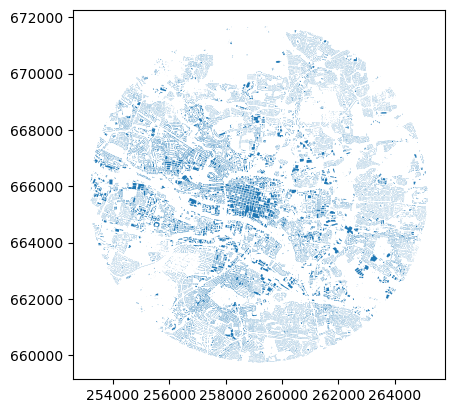

In [7]:
buildings.plot()

In [8]:
# buildings = momepy.preprocess(buildings.reset_index(), size=40,
#                               compactness=0.2, islands=True)

In [9]:
buildings

,geometry
0,"POLYGON ((253894.911 667992.009, 253894.504 66..."
3,"POLYGON ((257873.072 660535.923, 257874.349 66..."
5,"POLYGON ((260781.284 667382.518, 260777.467 66..."
10,"POLYGON ((258731.422 660456.589, 258733.748 66..."
30,"POLYGON ((254252.042 665895.371, 254225.829 66..."
...,...
286472,"POLYGON ((261598.050 664298.257, 261601.310 66..."
286507,"POLYGON ((263173.291 664689.249, 263174.015 66..."
286512,"POLYGON ((262230.343 670792.684, 262234.060 67..."
286519,"POLYGON ((262847.006 666028.488, 262849.217 66..."


In [10]:
# Check for invalid geometries
invalid_geometries = buildings[~buildings.geometry.is_valid]

# If there are invalid geometries, attempt to fix them
if not invalid_geometries.empty:
    print(f"Found {len(invalid_geometries)} invalid geometries. Attempting to fix...")
    buildings.geometry = buildings.geometry.buffer(0)

    # Recheck for invalid geometries
    still_invalid = buildings[~buildings.geometry.is_valid]
    if still_invalid.empty:
        print("All invalid geometries fixed.")
    else:
        print(f"Could not fix {len(still_invalid)} geometries.")
else:
    print("No invalid geometries found.")

Found 2 invalid geometries. Attempting to fix...
All invalid geometries fixed.


In [ ]:
buildings = buildings[buildings.geometry.area >= 25]

In [11]:
buildings['uID'] = momepy.unique_id(buildings)

In [12]:
water_bodies_boundaries = []

# Explode the GeoDataFrame into a GeoSeries of polygons and multipolygons
gs = water.explode()

# Convert each polygon into a MultiLineString
mls = gs.geometry.boundary

# Convert the MultiLineString into a DataFrame
water_bodies = gpd.GeoDataFrame({'geometry': mls})

for water_body in water_bodies.geometry:
    # Create a LineString object from the coordinates
    water_bodies_boundaries.append(water_body)

# # Create a GeoDataFrame of the water area boundaries
water_bodies_boundaries = gpd.GeoDataFrame({'geometry': water_bodies_boundaries}).reset_index(drop=True)

/tmp/ipykernel_5010/893087771.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = water.explode()


In [13]:
# enclosures = momepy.enclosures(streets, limit=study_area, additional_barriers=[water_bodies_boundaries, rail])

In [14]:
num_chunks = ceil(len(buildings) / 1400000)

In [15]:
# def split_bounds(bounds, num_chunks):
#     minx, miny, maxx, maxy = bounds
#     width = maxx - minx
#     height = maxy - miny

#     # Assuming a square grid for simplicity
#     chunks_per_side = math.ceil(math.sqrt(num_chunks))
#     chunk_width = width / chunks_per_side
#     chunk_height = height / chunks_per_side

#     chunks = []
#     for i in range(chunks_per_side):
#         for j in range(chunks_per_side):
#             new_minx = minx + i * chunk_width
#             new_miny = miny + j * chunk_height
#             new_maxx = new_minx + chunk_width
#             new_maxy = new_miny + chunk_height

#             # Create a new bounding box (as a shapely box) for each chunk
#             chunk_bounds = box(new_minx, new_miny, new_maxx, new_maxy)
#             chunks.append(chunk_bounds)

#     return gpd.GeoSeries(chunks)

# # Example usage
# chunks = split_bounds(enclosures.total_bounds, num_chunks)

In [16]:
# chunks = gpd.GeoDataFrame(geometry = chunks)
# chunks["chunk_ID"] = range(len(chunks))
# enclosures["centroid"] = enclosures.centroid
# enclosures = enclosures.sjoin(chunks, how="left")
# enclosures = enclosures[["geometry", "chunk_ID", "eID"]]

In [17]:
# chunks

In [18]:
# # Plotting each chunk
# fig, ax = plt.subplots()
# chunks.plot(ax=ax, edgecolor='black', facecolor='none')
# enclosures.plot(ax=ax, column='chunk_ID', categorical=True, legend=True)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=buildings.crs)
# plt.show()

In [19]:
# buildings = buildings[["geometry"]].sjoin(enclosures, how="left")

In [20]:
# buildings = buildings.dropna()[["geometry", "chunk_ID"]]
# buildings["uID"] = range(len(buildings))
# old_buildings = buildings
# buildings = buildings.set_geometry('geometry')

In [21]:
# buildings = buildings.to_crs(local_crs)
# enclosures = enclosures.to_crs(local_crs)

In [22]:
# tessellation = gpd.GeoDataFrame()

# for index, chunk in tqdm(chunks.iterrows(), total= chunks.shape[0]):
#     chunk_tessellation = momepy.Tessellation(buildings[buildings["chunk_ID"]==index], unique_id='uID', enclosures=enclosures[enclosures["chunk_ID"] == index], use_dask = True).tessellation
#     tessellation = pd.concat([tessellation, chunk_tessellation])
    
# tessellation_old = tessellation

In [23]:
limit = study_area
enclosures = momepy.enclosures(streets, limit=study_area.iloc[0]["geometry"], additional_barriers=[rail, rivers])
tessellation = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures).tessellation

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/momepy/elements.py:1001: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = enclosures.sindex.query_bulk(
/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/momepy/elements.py:451: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = buildings.sindex.query_bulk(
/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/momepy/elements.py:510: FutureWarning: The behavior of DataFrame concatenati

In [24]:
# tessellation.plot()

In [ ]:
tessellation.to_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [ ]:
# tessellation = gpd.read_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [ ]:
tessellation=tessellation.sort_values(by='uID').reset_index(drop=True).dropna(subset=['uID'])

In [ ]:
duplicate_gdf = tessellation[tessellation.duplicated('uID', keep=False)]

In [ ]:
@delayed
def find_valid_from_multiples(gdf, building):
    gdf = gdf[gdf.intersects(building)]
        
    if gdf.shape[0] > 1:
        smallest_area = gdf.geometry.area.idxmin()
        return gdf.loc[[smallest_area]]
    return gdf

# Using a list comprehension for conciseness and efficiency
results = dask.compute([
    find_valid_from_multiples(duplicate_gdf[duplicate_gdf['uID'] == uid].reset_index(), buildings[buildings["uID"] == uid].geometry.iloc[0])
    for uid in duplicate_gdf["uID"].unique()
])

# Concatenate the results into a single GeoDataFrame
a = gpd.GeoDataFrame(pd.concat(results[0], ignore_index=True))
tessellation = gpd.GeoDataFrame(pd.concat([tessellation, a], ignore_index=True))


In [ ]:
tessellation

In [ ]:
tessellation = tessellation.drop("eID", axis = 1)

In [ ]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_buildings = set(buildings['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
tessellation = tessellation[tessellation['uID'].isin(uIDs_buildings)]


In [ ]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_tessellation = set(tessellation['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
buildings = buildings[buildings['uID'].isin(uIDs_tessellation)]


In [ ]:
tessellation

In [ ]:
tessellation = tessellation[["uID", "geometry"]]
buildings = buildings[["uID", "geometry"]]

In [ ]:
tessellation[tessellation.duplicated('uID', keep=False)]

In [ ]:
combined = tessellation.merge(buildings, on='uID', how='inner').reset_index()
combined["uID"] = range(len(combined))
combined

In [ ]:
tessellation = gpd.GeoDataFrame(combined[["uID", "geometry_x"]], geometry='geometry_x')
tessellation = tessellation.rename(columns={'geometry_x': 'geometry'})

In [ ]:
tessellation = tessellation.set_geometry("geometry", crs=local_crs)

In [ ]:
buildings = gpd.GeoDataFrame(combined[["uID", "geometry_y"]], geometry='geometry_y')
buildings = buildings.rename(columns={'geometry_y': 'geometry'})

In [ ]:
buildings = buildings.set_geometry("geometry", crs=local_crs)

In [ ]:
tessellation.to_parquet(f"../output/{place}/tessellation_p2.pq")

In [ ]:
buildings.to_parquet(f"../output/{place}/buildings_p2.pq")

In [ ]:
streets.to_parquet(f"../output/{place}/streets_p2.pq")

In [ ]:
# # Create a figure and axis

# # Plot streets in blue on the same axis
# streets.plot(ax=ax, color='blue')

# # Plot buildings in red on the same axis
# buildings.plot(ax=ax, color='red')

# tessellation.plot(ax = ax, color = 'green')

# # Show the plot
# plt.show()